# Face Verification on labelled Faces in the Wild

Face verification is the task of comparing a candidate face to another, and verifying whether it is a match. It is a one-to-one mapping where you have to check if this person is the correct one.

In this tutorial we use [face-reidentification-retail-0095](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/face-reidentification-retail-0095) which is available on Open Model Zoo

# Preparation


## Imports

In [2]:
import random
import time
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
from IPython.display import Markdown, display
from numpy.linalg import norm
from openvino.runtime import Core
from prettytable import PrettyTable
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from torchvision.datasets import LFWPairs
from tqdm.notebook import tqdm
from yaspin import yaspin

sys.path.append("/content/openvino_notebooks/notebooks/utils")
from utils.notebook_utils import to_rgb


## Settings and Configuration


In [4]:
model_dir = Path("model")
model_name = "face-reidentification-retail-0095"
precision = "FP32"
model_xml_path = model_dir / "intel" / model_name / precision / f"{model_name}.xml"

model_dir.mkdir(exist_ok=True)


Device: CPU


## Download Model from Open Model Zoo

We use `omz_downloader`, which is a command-line tool from the openvino-dev package. `omz_downloader` automatically creates a directory structure and downloads the selected model.

In [ ]:
download_command = f"omz_downloader --name {model_name} -o {model_dir} --precision {precision}"
display(Markdown(f"Download command: `{download_command}`"))
with yaspin(text=f"Downloading {model_name}") as sp:
    download_result = !$download_command
    print(download_result)
    sp.text = f"Finished downloading {model_name}"
    sp.ok("✔")

## Load Model

Load the model in Inference Engine with `ie.read_model`, compile it for the specified device with `ie.compile_model`, and get information about the network inputs and outputs.

In [15]:
ie = Core()
model = ie.read_model(model=model_xml_path, weights=model_xml_path.with_suffix(".bin"))
compiled_model = ie.compile_model(model=model)

input_key = compiled_model.input(0)
output_key = compiled_model.output(0)

network_input_shape = list(input_key.shape)
image_height, image_width = network_input_shape[2:]
print(
    f"The network expects inputs with a width of {image_width}, "
    f"height of {image_height}"
)


The network expects inputs with a width of 128, height of 128


# Face Verification

## Loading Dataset
We use [LFW (Labelled Faces in the Wild)](http://vis-www.cs.umass.edu/lfw/) dataset to perform validation.

The dataset class [LFWPairs](https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html) returns a tuple of three elements: Image1, Image2 and Label specifying whether both images belong to same person or not.

In [16]:
transform = T.Compose(
    [
        T.CenterCrop((105, 105)),
        T.Resize((128, 128)),
        T.Lambda(lambda x: np.array(x).transpose((2, 0, 1))[::-1]),
    ]
)
dataset = LFWPairs(root="data", download=True, transform=transform)


Files already downloaded and verified


# Visualize few datapoints

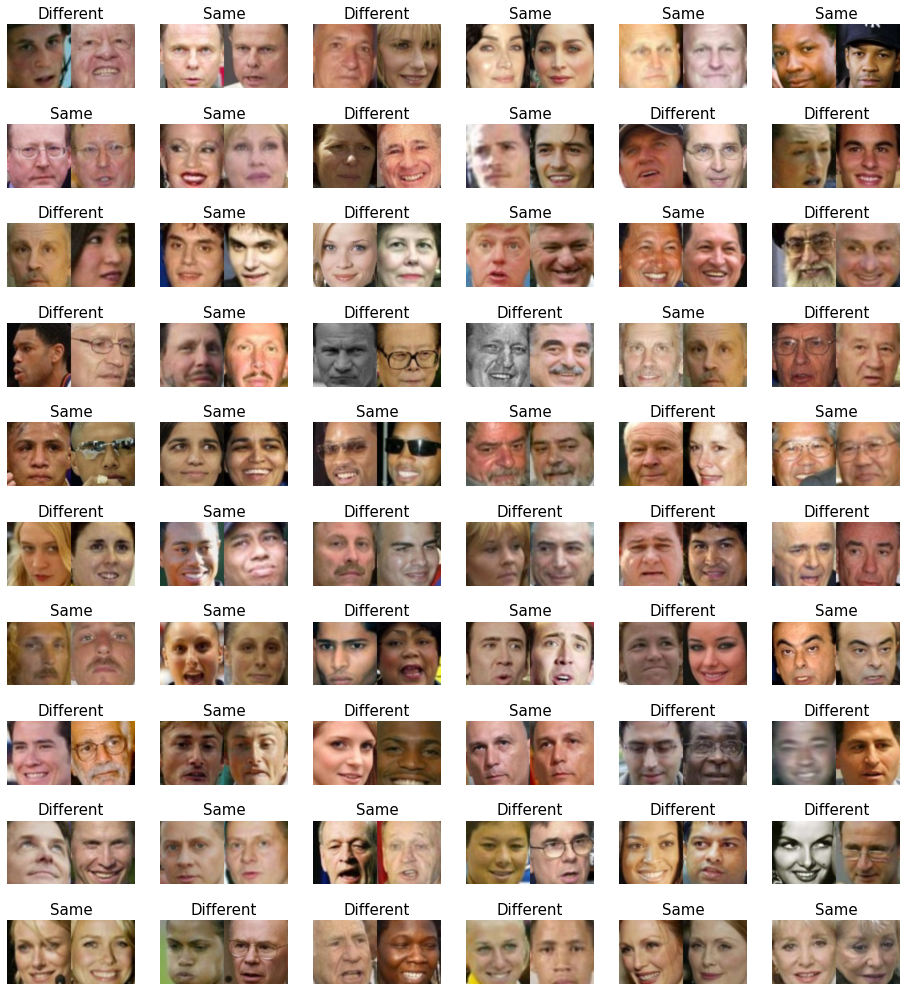

In [17]:
_, axxr = plt.subplots(10, 6, figsize=(16, 18))
for ax in axxr.flatten():
    idx = random.randint(0, len(dataset) - 1)
    img1, img2, t = dataset[idx]
    img1, img2 = img1.transpose(1, 2, 0), img2.transpose(1, 2, 0)
    img = cv2.hconcat([to_rgb(img1), to_rgb(img2)])
    ax.imshow(img)
    ax.title.set_text("Same" if t else "Different")
    ax.title.set_size(15)
    ax.axis("off")
plt.show()


# Run Inference

Running inference on one sample

In [8]:
idx = random.randint(0, len(dataset) - 1)
sample = dataset[idx][0]
print("Sample shape [before]:", sample.shape)

# The model requires input to be of shape (1, 3, 128, 128)
# Therefore to add new dimension we use np.newaxis
sample = sample[np.newaxis, ...]
print("Sample shape [after]:", sample.shape)

# Passing through the model
embeddings = compiled_model([sample])[output_key]
print("Output shape", embeddings.shape)


Sample shape [before]: (3, 128, 128)
Sample shape [after]: (1, 3, 128, 128)
Output shape (1, 256, 1, 1)


Running inference on whole data.
Using the normalized image embeddings we calucate Euclidean Distance as:

$$ d(x, y) = \left(\frac{x}{||\mathbf{x}||_2} - \frac{y}{||\mathbf{y}||_2}\right)^2 $$


In [9]:
def dist(enc1, enc2):
    return np.square((enc1 / norm(enc1) - enc2 / norm(enc2))).sum(-1)


In [12]:
distances = []
targets = []
start_time = time.perf_counter()

for i in tqdm(range(len(dataset))):
    pair1, pair2, target = dataset[i]
    embd1 = compiled_model([pair1[np.newaxis, ...]])[output_key].squeeze()
    embd2 = compiled_model([pair2[np.newaxis, ...]])[output_key].squeeze()
    distance = dist(embd1, embd2)
    distances.append(distance)
    targets.append(target)

stop_time = time.perf_counter()
duration = stop_time - start_time
print(f"Inference time taken: {duration:.2f}")
distances = np.array(distances)
targets = np.array(targets)


  0%|          | 0/6000 [00:00<?, ?it/s]

Inference time taken: 154.20 seconds.


# 10-Fold Validation
This approach of [k-Fold Cross Validation](https://machinelearningmastery.com/k-fold-cross-validation/) involves dividing the set of observations into 10 groups, or folds. The first fold is treated as a validation set, and the method is fit on the remaining 9 folds.


We shall first find evaluation matrix which looks like: 
 
 ![Confusion Matrix](https://miro.medium.com/proxy/1*sJJZnGduFsNxlqWLMsrmBw.png)


In [18]:
def calculate_metrics(threshold, dist, is_same):
    is_not_same = np.logical_not(is_same)
    preds = np.less(dist, threshold)

    true_accepts = np.sum(np.logical_and(preds, is_same))
    false_accepts = np.sum(np.logical_and(preds, is_not_same))
    # false_rejects = np.sum(np.logical_and(np.logical_not(preds), is_same))
    true_rejects = np.sum(np.logical_and(np.logical_not(preds), is_not_same))

    true_positive_rate = true_accepts / (
        is_same.sum() + 1e-16
    )  # sensitivity, recall, val
    false_positive_rate = false_accepts / (
        is_not_same.sum() + 1e-16
    )  # (1-specificity), far

    precision = true_accepts / (true_accepts + false_accepts + 1e-16)
    # a ratio of correctly predicted positive observations to the total predicted positive observations
    accuracy = (true_accepts + true_rejects) / (
        is_same.sum() + is_not_same.sum() + 1e-16
    )
    # a ratio of correctly predicted observation to the total observations

    return true_positive_rate, false_positive_rate, precision, accuracy


The maximum distance between any two normalized embedding vectors will be 4.
Hence we will look for thresholds in range [0,4]

Next, we shall use [Youden's index](https://en.wikipedia.org/wiki/Youden%27s_J_statistic) to find the optimal threshold for distance between pairs.

In [20]:
NUM_FOLDS = 10
thresholds = np.arange(0, 4, 0.001)

num_pairs = len(distances)
num_thresholds = len(thresholds)
k_fold = KFold(n_splits=NUM_FOLDS)

true_positive_rates = np.zeros(NUM_FOLDS)
false_positive_rates = np.zeros(NUM_FOLDS)
precision = np.zeros(NUM_FOLDS)
accuracy = np.zeros(NUM_FOLDS)
best_distances = np.zeros(NUM_FOLDS)

indices = np.arange(num_pairs)

for fold_index, (train_set, test_set) in tqdm(
    enumerate(k_fold.split(indices)), total=NUM_FOLDS
):
    # Find the best distance threshold for the k-fold cross validation using the train set
    youdens = np.zeros(num_thresholds)
    for threshold_index, threshold in enumerate(thresholds):
        tpr, fpr, _, _ = calculate_metrics(
            threshold=threshold, dist=distances[train_set], is_same=targets[train_set]
        )
        youdens[threshold_index] = tpr - fpr  # sensitivity + specificity — 1
    best_threshold_index = np.argmax(youdens)

    # Test on test set using the best distance threshold
    (
        true_positive_rates[fold_index],
        false_positive_rates[fold_index],
        precision[fold_index],
        accuracy[fold_index],
    ) = calculate_metrics(
        threshold=thresholds[best_threshold_index],
        dist=distances[test_set],
        is_same=targets[test_set],
    )

    best_distances[fold_index] = thresholds[best_threshold_index]

threshold = np.mean(best_distances)


  0%|          | 0/10 [00:00<?, ?it/s]

$TAR@FAR=0.001$ means the rate that faces are successfully accepted (True Acceptance Rate) (TP/(TP+FN)) when     the rate that faces are incorrectly accepted (False Acceptance Rate) (FP/(TN+FP)) is 0.001 (The less the FAR value     the mode difficult it is for the model). i.e: 'What is the True Positive Rate of the model when only one false image in 1000 images is allowed?'.

In [21]:
t = PrettyTable(
    [
        "Accuracy on LFW",
        "Precision",
        "Best distance threshold",
        f"TAR @ FAR: {np.mean(false_positive_rates):.4f}",
    ]
)
t.add_row(
    "{:.4f}±{:.4f}, {:.4f}±{:.4f}, {:.2f}±{:.2f}, {:.4f}±{:.4f}".format(
        np.mean(accuracy),
        np.std(accuracy),
        np.mean(precision),
        np.std(precision),
        np.mean(best_distances),
        np.std(best_distances),
        np.mean(true_positive_rates),
        np.std(true_positive_rates),
    ).split(",")
)
print(t)


+-----------------+----------------+-------------------------+-------------------+
| Accuracy on LFW |   Precision    | Best distance threshold | TAR @ FAR: 0.0083 |
+-----------------+----------------+-------------------------+-------------------+
|  0.9817±0.0058  |  0.9916±0.0069 |         1.49±0.01       |    0.9717±0.0120  |
+-----------------+----------------+-------------------------+-------------------+


Lets plot [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the observations

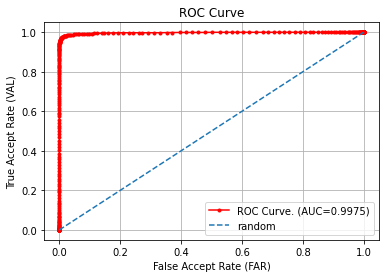

In [22]:
def draw_roc(distances, labels):
    thresholds = np.arange(0, 4, 0.01)
    num_thresholds = len(thresholds)
    tpr = np.zeros(num_thresholds)
    fpr = np.zeros(num_thresholds)
    for idx, threshold in enumerate(thresholds):
        tpr[idx], fpr[idx], _, _ = calculate_metrics(threshold, distances, labels)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, marker=".", c="r", label=f"ROC Curve. (AUC={roc_auc:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--", label="random")
    ax.grid()
    ax.title.set_text("ROC Curve")
    ax.set_xlabel("False Accept Rate (FAR)")
    ax.set_ylabel("True Accept Rate (VAL)")
    ax.legend()
    # ax.savefig('ROC_curve')
    plt.show()


draw_roc(distances, targets)


Visualing results.

<font color="green">Green</font> colored text shows correct prediction, while
<font color="red">Red</font> colored text shows wrong prediction

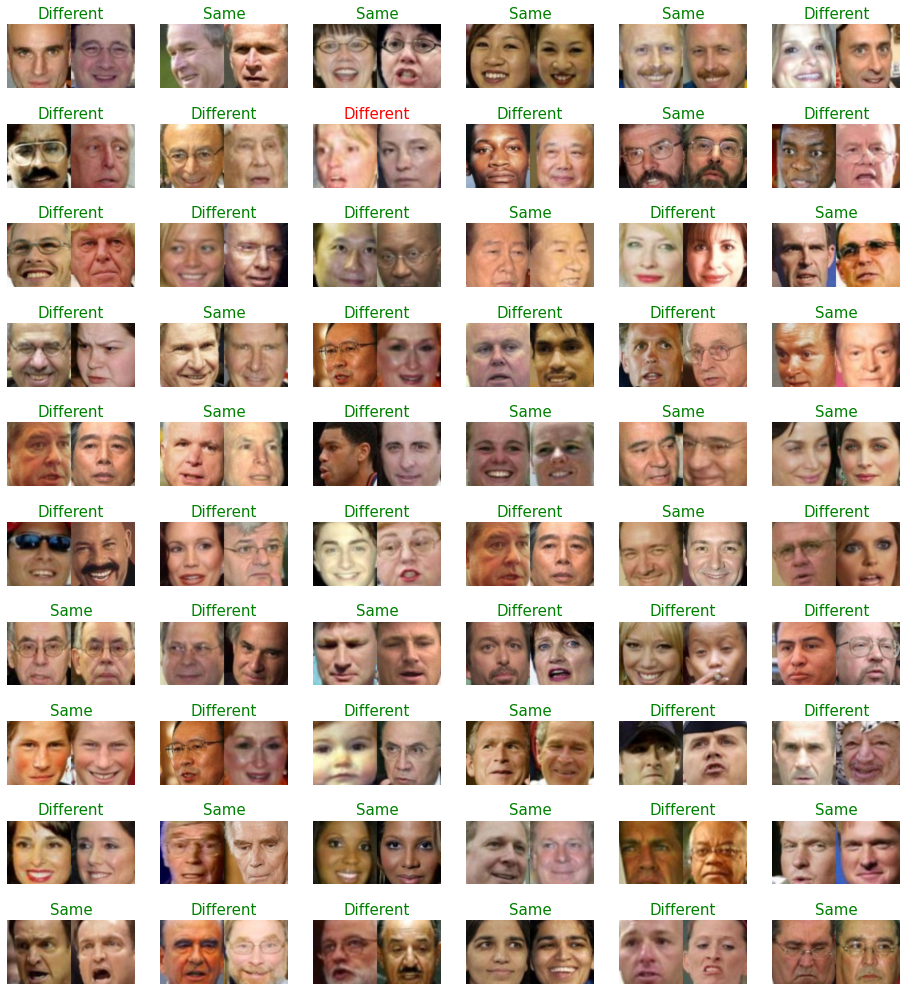

In [25]:
preds = np.less(distances, threshold)
_, axxr = plt.subplots(10, 6, figsize=(16, 18))
for ax in axxr.flatten():
    idx = random.randint(0, len(dataset) - 1)
    img1, img2, t = dataset[idx]
    p = int(preds[idx])
    img1, img2 = img1.transpose(1, 2, 0), img2.transpose(1, 2, 0)
    img = cv2.hconcat([to_rgb(img1), to_rgb(img2)])
    ax.imshow(img)
    title = "Same" if p else "Different"
    color = "green" if p == t else "red"
    ax.title.set_text(title)
    ax.title.set_color(color)
    ax.title.set_size(15)
    ax.axis("off")
plt.show()
